<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;"><a href="https://www.editorialuoc.cat/deep-learning" target="_blank\">Deep learning: Principios y fundamentos</a></p>
<p style="margin: 0; text-align:right;">Estudios de Informática, Multimedia y Telecomunicación</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Universitat Oberta de Catalunya (UOC)</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>


# Capítulo 9: Ejemplo de Redes neuronales para la transferencia de estilo (NST)

En este notebook queremos estudiar lo que se conoce como *__Neural Style Transfer (NST)__* (también conocidas como redes neuronales para la transferencia de estilo). Para ello vamos a utilizar la librería `Keras`de Python.

¿Pero que es *_NST_*?

Imagenímenos que tomamos una imagen de una tortuga y el cuadro del artista Katsushika Hokusai's *The Great Wave off Kanagawa*:

<img src="https://github.com/tensorflow/models/blob/master/research/nst_blogpost/Green_Sea_Turtle_grazing_seagrass.jpg?raw=1" alt="Drawing" style="width: 200px;"/>
<img src="https://github.com/tensorflow/models/blob/master/research/nst_blogpost/The_Great_Wave_off_Kanagawa.jpg?raw=1" alt="Drawing" style="width: 200px;"/>

[Image of Green Sea Turtle](https://commons.wikimedia.org/wiki/File:Green_Sea_Turtle_grazing_seagrass.jpg)
-By P.Lindgren [CC BY-SA 3.0  (https://creativecommons.org/licenses/by-sa/3.0)], from Wikimedia Common

<img src="https://github.com/tensorflow/models/blob/master/research/nst_blogpost/wave_turtle.png?raw=1" alt="Drawing" style="width: 500px;"/>

¿Es esto magia o simplemente aprendizaje profundo? Afortunadamente, esto no implica ninguna brujería: la transferencia de estilo es una técnica divertida e interesante que muestra las capacidades y representaciones internas de las redes neuronales.

El principio de la transferencia de estilo neural es definir dos funciones de distancia, una que describe cuán diferente es el contenido de dos imágenes, $ L_ {contenido} $, y otra que describe la diferencia entre dos imágenes en términos de su estilo, $ L_ { estilo} $. 


Para poder realizar este apartado necesitaremos asegurarnos de que tenemos instaladas las librerías `Tensorflow` y `Keras`. Para ello desde terminal escribiremos el siguiente comando: 

> pip install tensorflow

> pip install keras

Si alguno utiliza el entorno Conda también puede instalarse desde este entorno. 

Por otro lado, este es el apartado en el que estáis menos familiarizados por lo que a lo largo a lo largo del notebook os iremos dando una sería de enlaces a conceptos y ejemplos que os ayudarán a entender mejor lo que estamos haciendo. Es **altamente recomendable** leer con detenimiento los links y referencias indicadas y entender las explicaciones teóricas y los ejemplos de código proporcionados.

Para introducirnos en lo que es una red neuronal de transferencia de estilo os proporcionamos dos links a modo de introducción: 
- https://www.fritz.ai/style-transfer/
- https://towardsdatascience.com/a-brief-introduction-to-neural-style-transfer-d05d0403901d


En este proceso desarrollaremos los siguientes conceptos: 

- El concepto de **Eager Execution**
- Crearemos un subconjunto de nuestro modelo que nos dará acceso a las activaciones intermedias necesarias.
- Aprenderemos a usar modelos pre-entrenados y sus mapas de características
- Crearemos bucles de entrenamiento personalizados, en concreto, **examinaremos cómo configurar un optimizador para minimizar una pérdida dada con respecto a los parámetros de entrada**.

Para ello seguiremos siempre el esquema de trabajo que hemos desarrollado hasta el momento: 

1. Visulización de los datos
2. Preprocesamiento básico y preparación de los datos
3. Configuración de las funciones de pérdida
4. Creación del modelo 
5. Optimización para la función de pérdida

**NOTAS**: 
- Tener en cuenta que esta parte exige un cálculo intensivo por lo que el tiempo estimado de ejecución ronda las 2 horas para un ordenador de características estándar (solo usando la CPU). 
- Este ejemplo requiere el uso de TensorFlow 2.x. De lo contrario, parte del código podría no funcionar correctamente o debería adaptarse a la versión 1.x de TensorFlow.

### Importamos paquetes necesarios y configuramos modulos 

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl

import numpy as np
from PIL import Image
import time
import functools
import tensorflow as tf

from tensorflow.keras.preprocessing import image as kp_image
from tensorflow.keras import models
from tensorflow.keras import losses
from tensorflow.keras import layers
from tensorflow.keras import backend as K

mpl.rcParams["figure.figsize"] = (10, 10)
mpl.rcParams["axes.grid"] = False

print(tf.__version__)

2.15.1


Vamos a habilitar la [**Eager Execution**] 
* [Aprende más acerca de lo que es la eager execution](https://www.tensorflow.org/programmers_guide/eager)
* [Mírala en acción](https://www.tensorflow.org/get_started/eager)

In [2]:
# Nos aseguramos de que activamos la eager execution
try:
    tf.enable_eager_execution()
except Exception:
    pass

print("Eager execution: {}".format(tf.executing_eagerly()))

Eager execution: True


Elejimos dos imágenes cualquiera. Una la utilizaremos como **imagen de contenido** (*content image*) y la otra la utilizaremos de **imagen de estilo** (*style image*). Direcciona la ruta a esas imágenes. 

In [ ]:
content_path = "../figs/lion.jpg"  # Aquí pon la ruta a tu imagen de contenido
style_path = "../figs/violin.jpg"  # Aquí pon la ruta a tu imagen de estilo

Estas van a ser nuestros *inputs*. Nuestro objetivo es crear una imagen cuyo contenido sea el de nuestra imagen de contenido pero con el estilo de nuestra imagen de estilo. 

Para ello vamos a definir dos funciones:
- Una que cargará nuestras imágenes 
- y la otra que nos las mostrará

In [ ]:
def load_img(path_to_img):
    max_dim = 512
    img = Image.open(path_to_img)
    long = max(img.size)
    scale = max_dim / long
    resample = (
        Image.Resampling.LANCZOS if hasattr(Image, "Resampling") else Image.LANCZOS
    )
    img = img.resize((round(img.size[0] * scale), round(img.size[1] * scale)), resample)

    img = kp_image.img_to_array(img)

    # Necesitamos tener una matriz de imaǵenes que tenga las mismas dimensiones que nuestro bacth
    img = np.expand_dims(img, axis=0)
    return img

In [ ]:
def imshow(img, title=None):

    # Eliminamos la dimension del batch
    out = np.squeeze(img, axis=0)

    # Normalizamos para poder visualizar
    out = out.astype("uint8")
    plt.imshow(out)
    if title is not None:
        plt.title(title)
    plt.imshow(out)

Visualizamos la imagen de contenido y la imagen de estilo en la misma escala. Recuerda que para que nos funcione las imágenes tienen que estar en **uint8** (puesto que las imágenes de los pesos pre-entrenados están en ese formato). 

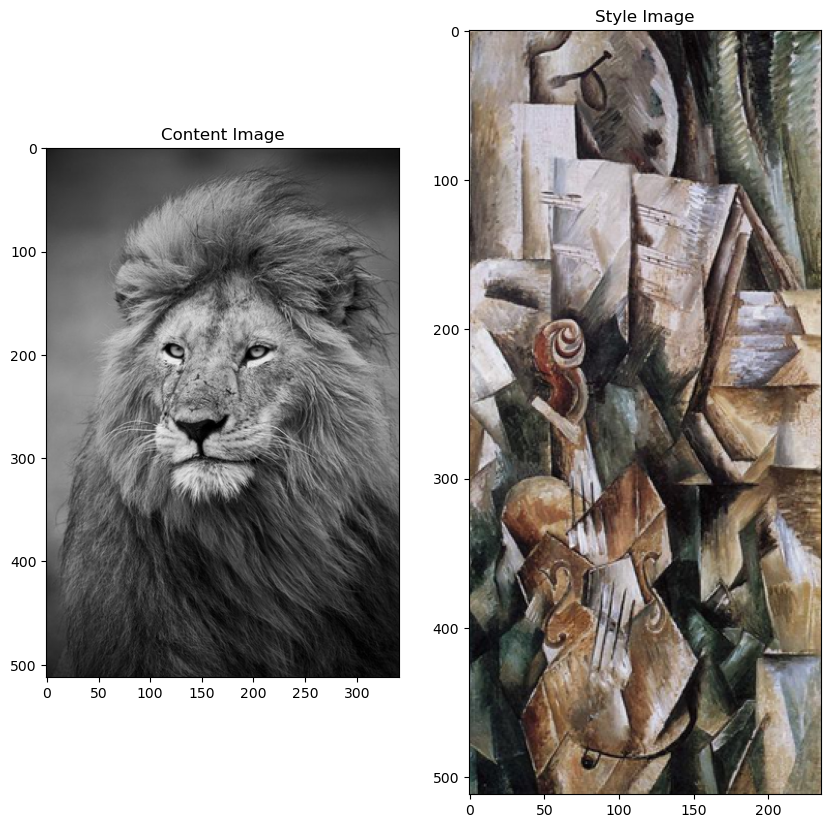

In [20]:
# Visualizamos la imagenes
plt.figure(figsize=(10, 10))

content = load_img(content_path).astype("uint8")
style = load_img(style_path).astype("uint8")

plt.subplot(1, 2, 1)
imshow(content, "Content Image")

plt.subplot(1, 2, 2)
imshow(style, "Style Image")
plt.show()

## Preparamos los datos
A continuación creamos los métodos que nos permitan cargar y preprocesar nuestras imágenes fácilmente. Realizamos el mismo proceso de preprocesamiento que el que se realiza con la arquitectura de red VGG. Las redes VGG se entrenan en la imagen con cada canal normalizado por `mean = [103.939, 116.779, 123.68]` y con los canales BGR. 
Nosotros para procesar nuestros datos vamos a usar los pesos ya entrenados de la arquitectura de red VGG19

In [ ]:
def load_and_process_img(path_to_img):
    img = load_img(path_to_img)
    img = tf.keras.applications.vgg19.preprocess_input(img)
    return img

Nuestra imagen optimizada puede tomar sus valores en cualquier lugar entre −∞ y ∞, por lo que debemos recortar para mantener nuestros valores dentro del rango 0-255. Esto es lo que hace la siguiente función:

In [ ]:
def deprocess_img(processed_img):
    x = processed_img.copy()
    if len(x.shape) == 4:
        x = np.squeeze(x, 0)
    assert len(x.shape) == 3, (
        "La imagen debe de tener dimensiones de "
        "dimension [1, height, width, channel] or [height, width, channel]"
    )
    if len(x.shape) != 3:
        raise ValueError("Input no valido")

    # Realizamos el inverso del paso de preprocesamiento
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]

    x = np.clip(x, 0, 255).astype("uint8")
    return x

### Definimos representaciones de contenido y estilo
Para obtener tanto el contenido como las representaciones de estilo de nuestra imagen, veremos algunas capas intermedias dentro de nuestro modelo. 
A medida que profundizamos en el modelo, estas capas intermedias representan características de orden superior. 
En este caso, estamos utilizando la arquitectura de red VGG19, una red de clasificación de imágenes previamente entrenada. Estas capas intermedias son necesarias para definir la representación del contenido y el estilo de nuestras imágenes. Para una imagen de entrada, intentaremos hacer coincidir las representaciones de destino de contenido y estilo correspondientes en estas capas intermedias. Esto lo hacemos de esta manera porque las redes neuronales convolucionales (a la que pertenece la VGG19) son capaces de capturar invarianzas y características definitorias de las clases que son independientes del ruido de fondo. Es decir, el modelo sirve como un extractor de características complejas; por lo tanto, al acceder a capas intermedias, podemos describir el contenido y el estilo de las imágenes de entrada. 

In [ ]:
# Capa de contenido donde extraeremos nuestros mapas de características
content_layers = ["block5_conv2"]

# Capas de estilo que nos interesan
style_layers = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

## Contrucción  del modelo
En este caso, cargamos [VGG19](https://keras.io/applications/#vgg19) y alimentamos nuestro tensor de entrada al modelo. Esto nos permitirá extraer los mapas de características (y posteriormente las representaciones de contenido y estilo) y las imágenes generadas.

Para acceder a las capas intermedias correspondientes a nuestros mapas de características de estilo y contenido utilizamos Keras [**Functional API**](https://keras.io/getting-started/functional-api-guide/).

Con la API funcional, definir un modelo simplemente implica definir la entrada y la salida, de la forma

`model = Model (entradas, salidas)`

In [ ]:
def get_model():
    """Crea nuestro modelo con acceso a capas intermedias.

    Esta función cargará el modelo VGG19 y accederá a las capas intermedias.
    Estas capas se usarán para crear un nuevo modelo que tomará la imagen de entrada
    y devolver los resultados de estas capas intermedias del modelo VGG.

    Return:
      Devuelve un modelo de Keras que toma entradas de imagen y emite el estilo y
        contenido de capas intermedias.
    """
    # Carguamos nuestro modelo. Cargamos VGG preentrenado con los datos de ImageNet
    vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights="imagenet")
    vgg.trainable = False

    # Obtenemos las capas de salida correspondientes a las capas de estilo y contenido
    style_outputs = [vgg.get_layer(name).output for name in style_layers]
    content_outputs = [vgg.get_layer(name).output for name in content_layers]
    model_outputs = style_outputs + content_outputs

    # Construimos el modelo
    return models.Model(vgg.input, model_outputs)

En el fragmento de código anterior, cargamos nuestra red de clasificación de imágenes previamente entrenada. Luego tomamos las capas de interés como las hemos definido anteriormente. Posteriormente definimos un modelo configurando las entradas del modelo a una imagen y las salidas a las salidas de las capas de estilo y contenido. En otras palabras, ¡creamos un modelo que tomará una imagen de entrada y generará el contenido y el estilo de las capas intermedias!

## Definimos y creamos nuestras funciones de pérdidas (distancias de contenido y de estilo)

En esta sección definimos dos funciones de pérdida:
- la función de pérdida de contenido
- la función de pérdida de estilo. 

La **función de pérdida de contenido** garantiza que las activaciones de las capas superiores sean similares entre la imagen de contenido y la imagen generada. La **función de pérdida de estilo** asegura que la correlación de activaciones en todas las capas sea similar entre la imagen de estilo y la imagen generada. 

<strong>Función de perdida de contenido</strong>


Nuestra definición de **pérdida de contenido** es en realidad bastante simple. Le pasaremos a la red la imagen de contenido deseada y nuestra imagen de entrada base. Esto devolverá los resultados de la capa intermedia (de las capas definidas anteriormente) de nuestro modelo. Luego simplemente tomamos la distancia euclidiana entre las dos representaciones intermedias de esas imágenes.

Más formalmente, la pérdida de contenido es una función que describe la distancia del contenido desde nuestra imagen de salida $x$ y nuestra imagen de contenido, $p$. Sea $C_{nn}$ una red neuronal convolucional profunda pre-entrenada. Nuevamente, en este caso usamos [VGG19](https://keras.io/applications/#vgg19). Sea $X$ cualquier imagen, luego $C_{nn}(X)$ es la red alimentada por X. 

$F^l_{ij}(x) \in C_{nn}(x)$ y $P^l_{ij}(p) \in C_{nn}(p)$ describe la representación de la característica intermedia respectiva de la red con las entradas $x$ y $p$ en la capa $l$. Luego describimos la distancia de contenido (pérdida) formalmente como: 

$$L^l_{contenido} (p,x) = \sum_{i, j} (F^l_{ij}(x) - P^l_{ij}(p))^2 $$

Realizamos la [**backpropagation**](https://towardsdatascience.com/understanding-backpropagation-algorithm-7bb3aa2f95fd) (propagación hacia atrás) de la forma habitual, de modo que minimizamos esta pérdida de contenido. Por lo tanto, cambiamos la imagen inicial hasta que genera una respuesta similar en una determinada capa (definida en content_layer) como la imagen de contenido original.


In [ ]:
def get_content_loss(base_content, target):
    return tf.reduce_mean(tf.square(base_content - target))

<strong>Función de perdida de estilo</strong>

La pérdida de estilo tiene una programación un poco más complicada, pero sigue el mismo principio, esta vez alimentando a nuestra red la imagen de entrada base y la imagen de estilo. Sin embargo, en lugar de comparar las salidas intermedias sin procesar de la imagen de entrada base y la imagen de estilo, comparamos las [**matrices de Gramm**](https://es.wikipedia.org/wiki/Matriz_de_Gram) de las dos salidas.

Matemáticamente, describimos la pérdida de estilo de la imagen de entrada base, $x$, y la imagen de estilo, $a$, como la distancia entre la representación de estilo (las matrices de Gramm) de estas imágenes. 

Describimos la representación de estilo de una imagen como la correlación entre diferentes respuestas de filtro dadas por la matriz de Gram $G^l$, donde $G^l_{ij}$ es el producto interno entre el mapa de características vectorizadas $i$ y $j$ en la capa $l$. Podemos ver que $G ^l_{ij}$ generado sobre el mapa de características para una imagen dada representa la correlación entre los mapas de características $i$ y $j$.

Para generar un estilo para nuestra imagen de entrada base, realizamos un [**descenso de gradiente**](https://ruder.io/optimizing-gradient-descent/) desde la imagen de contenido para transformarla en una imagen que coincida con la representación de estilo de la imagen original. 

Esto lo hacemos minimizando la distancia cuadrática media entre el mapa de correlación de características de la imagen de estilo y la imagen de entrada. La contribución de cada capa a la pérdida total de estilo se describe en
$$E_l=\frac{1}{4N_l^2M_l^2}\sum_{i, j}(G ^l_{ij}-A^l_{ij})^2$$

donde $G^l_{ij}$ y $A^l_{ij}$ son la representación de estilo respectiva en la capa $l$ de $x$ y $a$. $N_l$ describe el número de mapas de características, cada uno de tamaño $M_l= altura * ancho$. Por lo tanto, la pérdida total de estilo en cada capa es


$$L_{estilo}(a,x) = \sum_{l \in L}w_lE_l$$

donde ponderamos la contribución de la pérdida de cada capa por algún factor $w_l$. En nuestro caso, ponderamos cada capa por igual ($w_l =\frac{1}{|L|}$)

In [ ]:
def gram_matrix(input_tensor):
    # We make the image channels first
    channels = int(input_tensor.shape[-1])
    a = tf.reshape(input_tensor, [-1, channels])
    n = tf.shape(a)[0]
    gram = tf.matmul(a, a, transpose_a=True)
    return gram / tf.cast(n, tf.float32)


def get_style_loss(base_style, gram_target):
    """Esperamos dos images de dimensiones h, w, c"""

    # Altura, anchura y número de filtros de cada capa
    # Escalamos la pérdida en una capa dada por el tamaño del mapa de características y la cantidad de filtros
    height, width, channels = base_style.get_shape().as_list()
    gram_style = gram_matrix(base_style)

    return tf.reduce_mean(
        tf.square(gram_style - gram_target)
    )  # / (4. * (canales ** 2) * (ancho * alto) ** 2)

Si no estás familiarizado con el descenso de gradiente / propagación hacia atrás o necesitas un repaso, definitivamente deberías consultar este [**interesante recurso**](https://developers.google.com/machine-learning/crash-course/reducing-loss/gradient-descent).

En este caso, utilizamos el optimizador [**Adam**](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam) para minimizar nuestra pérdida. Actualizamos iterativamente nuestra imagen de salida de modo que minimice nuestra pérdida: no actualizamos los pesos asociados con nuestra red, sino que entrenamos nuestra imagen de entrada para minimizar la pérdida. Para hacer esto, debemos saber cómo calculamos nuestras pérdidas y gradientes.

Ahora definiremos una pequeña función auxiliar que cargará nuestro contenido e imagen de estilo, los alimentaremos a través de nuestra red, que luego generará las representaciones de contenido y estilo de nuestro modelo. 

In [ ]:
def get_feature_representations(model, content_path, style_path):
    """Función auxiliar para calcular nuestras representaciones de características de contenido y estilo.

    Esta función simplemente cargará y preprocesará tanto el contenido como el estilo.

    Argumentos:
      modelo: El modelo que estamos usando.
      content_path: la ruta a la imagen de contenido.
      style_path: la ruta a la imagen de estilo

    Return:
      Devuelve las características de estilo y las características de contenido.
    """
    # Cargamos nuestras imágenes
    content_image = load_and_process_img(content_path)
    style_image = load_and_process_img(style_path)

    # Computa outputs
    style_outputs = model(style_image)
    content_outputs = model(content_image)

    # Obtiene las representaciones de estilo y contenido de nuestro modelo
    style_features = [
        style_layer[0] for style_layer in style_outputs[:num_style_layers]
    ]
    content_features = [
        content_layer[0] for content_layer in content_outputs[num_style_layers:]
    ]
    return style_features, content_features

### Calcular la pérdida y los gradientes
Aquí usamos [**tf.GradientTape**](https://www.tensorflow.org/programmers_guide/eager#computing_gradients) para calcular el gradiente.

In [ ]:
def compute_loss(
    model, loss_weights, init_image, gram_style_features, content_features
):
    """Esta función calculará la pérdida pérdida total.

    Argumentos:
      modelo: el modelo que nos dará acceso a las capas intermedias
      loss_weights: los pesos de cada contribución de cada función de pérdida.
        (peso de estilo, peso de contenido y peso de variación total)
      init_image: nuestra imagen base inicial. Esta imagen es lo que estamos actualizando con
        nuestro proceso de optimización.
      gram_style_features: matrices de Gramm calculadas previamente correspondientes a
        capas de estilo definidas de interés.
      content_features: salidas calculadas previamente de capas de contenido definidas de
        interesar.

    Return:
      Devuelve la pérdida total, la pérdida de estilo, la pérdida de contenido y la pérdida variacional total
    """
    style_weight, content_weight = loss_weights

    # Alimentamos con nuestra imagen nuestro modelo. Esto nos dará el contenido y
    # las representaciones de estilo en nuestras capas deseadas.
    model_outputs = model(init_image)

    style_output_features = model_outputs[:num_style_layers]
    content_output_features = model_outputs[num_style_layers:]

    style_score = 0
    content_score = 0

    # Acumulación de pérdidas de estilo de todas las capas
    # Aquí ponderamos igual cada contribución de cada capa de pérdida
    weight_per_style_layer = 1.0 / float(num_style_layers)
    for target_style, comb_style in zip(gram_style_features, style_output_features):
        style_score += weight_per_style_layer * get_style_loss(
            comb_style[0], target_style
        )

    # Acumulación de pérdidas de contenido de todas las capas
    weight_per_content_layer = 1.0 / float(num_content_layers)
    for target_content, comb_content in zip(content_features, content_output_features):
        content_score += weight_per_content_layer * get_content_loss(
            comb_content[0], target_content
        )

    style_score *= style_weight
    content_score *= content_weight

    # Obtiene las pérdidas totales
    loss = style_score + content_score
    return loss, style_score, content_score

In [ ]:
def compute_grads(cfg):
    with tf.GradientTape() as tape:
        all_loss = compute_loss(**cfg)

    # Calculamos los gradientes de las imágenes de input
    total_loss = all_loss[0]
    return tape.gradient(total_loss, cfg["init_image"]), all_loss

In [ ]:
import IPython.display


def run_style_transfer(
    content_path, style_path, num_iterations=1000, content_weight=1e3, style_weight=1e-2
):

    # No necesitamos,ni queremos entrenar ninguna capa de nuestro modelo, así que establecemos
    # su entrenamiento en falso
    model = get_model()
    for layer in model.layers:
        layer.trainable = False

    # Obtenemmos las representaciones de características de estilo y contenido
    # (de nuestras capas intermedias especificadas)
    style_features, content_features = get_feature_representations(
        model, content_path, style_path
    )
    gram_style_features = [
        gram_matrix(style_feature) for style_feature in style_features
    ]

    # Establecemos imagen inicial
    init_image = load_and_process_img(content_path)
    init_image = tf.Variable(init_image, dtype=tf.float32)
    # Create our optimizer
    opt = tf.optimizers.Adam(learning_rate=5, beta_1=0.99, epsilon=1e-1)

    # Para las visualización de las imágenes intermedias. Durante el proceso veremos como va cambiando la imagen
    iter_count = 1

    # Guardamos nuestro mejor resultado
    best_loss, best_img = float("inf"), None

    # Creamos una configuración "agradable"
    loss_weights = (style_weight, content_weight)
    cfg = {
        "model": model,
        "loss_weights": loss_weights,
        "init_image": init_image,
        "gram_style_features": gram_style_features,
        "content_features": content_features,
    }

    # Para la visualización
    num_rows = 2
    num_cols = 5
    display_interval = num_iterations / (num_rows * num_cols)
    start_time = time.time()
    global_start = time.time()

    norm_means = np.array([103.939, 116.779, 123.68])
    min_vals = -norm_means
    max_vals = 255 - norm_means

    imgs = []
    for i in range(num_iterations):
        grads, all_loss = compute_grads(cfg)
        loss, style_score, content_score = all_loss
        opt.apply_gradients([(grads, init_image)])
        clipped = tf.clip_by_value(init_image, min_vals, max_vals)
        init_image.assign(clipped)
        end_time = time.time()

        if loss < best_loss:
            # Actualizamos la mejor pérdida y la mejor imagen de la pérdida total
            best_loss = loss
            best_img = deprocess_img(init_image.numpy())

        if i % display_interval == 0:
            start_time = time.time()

            # Use el método .numpy () para obtener la matriz numpy concreta
            plot_img = init_image.numpy()
            plot_img = deprocess_img(plot_img)
            imgs.append(plot_img)
            IPython.display.clear_output(wait=True)
            IPython.display.display_png(Image.fromarray(plot_img))
            print("Iteration: {}".format(i))
            print(
                "Total loss: {:.4e}, "
                "style loss: {:.4e}, "
                "content loss: {:.4e}, "
                "time: {:.4f}s".format(
                    loss, style_score, content_score, time.time() - start_time
                )
            )
    print("Total time: {:.4f}s".format(time.time() - global_start))
    IPython.display.clear_output(wait=True)
    plt.figure(figsize=(14, 4))
    for i, img in enumerate(imgs):
        plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])

    return best_img, best_loss

Visualizamos todas las imágenes intermedias de las capas intermedias, para ello utiliza la función definida anteriormente `run_style_transfer`.

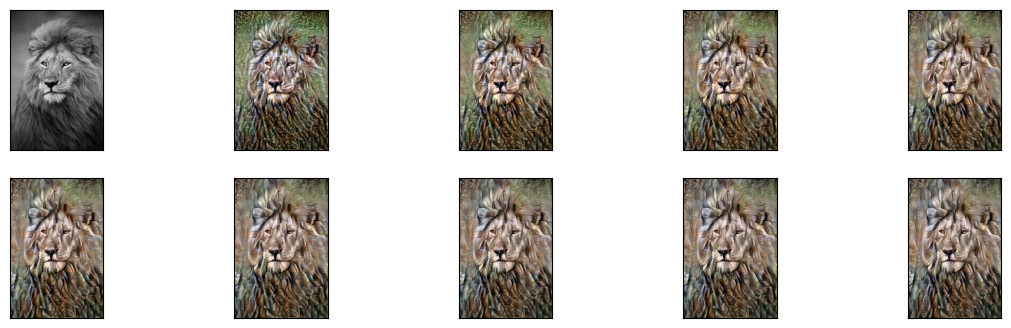

In [17]:
best, best_loss = run_style_transfer(content_path, style_path, num_iterations=1000)

## Visualizamos outputs


Visualizamos la imagen de contenido, la imagen de estilo y la imagen final.

In [18]:
def show_results(best_img, content_path, style_path, show_large_final=True):
    plt.figure(figsize=(10, 5))
    content = load_img(content_path)
    style = load_img(style_path)

    plt.subplot(1, 2, 1)
    imshow(content, "Content Image")

    plt.subplot(1, 2, 2)
    imshow(style, "Style Image")

    if show_large_final:
        plt.figure(figsize=(10, 10))

        plt.imshow(best_img)
        plt.title("Output Image")
        plt.show()

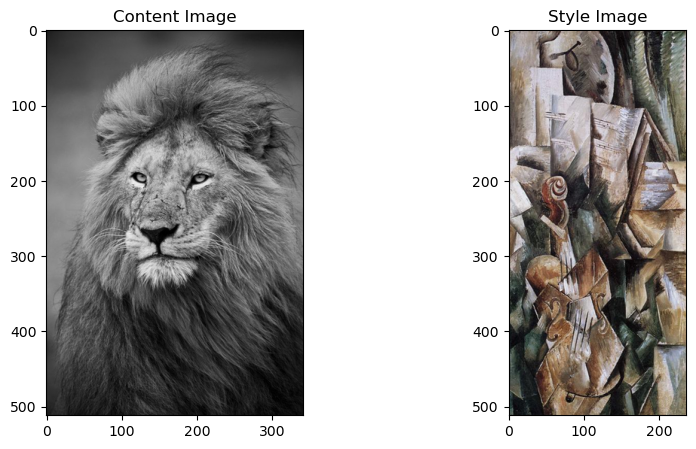

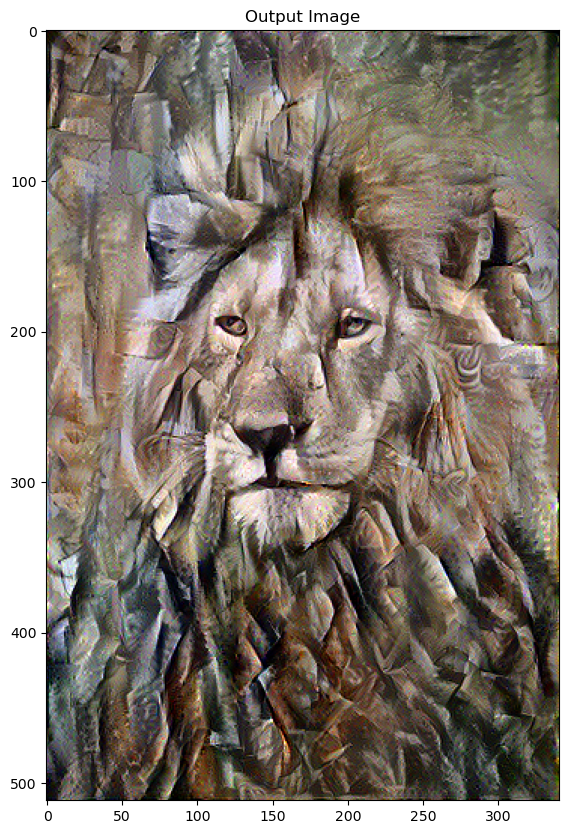

In [19]:
show_results(best, content_path, style_path)

# Conclusiones

Hemos aprendido algo sobre la transferencia de estilo neuronal. En resumen, la transferencia de estilo neuronal nos ha permitido combinar dos imágenes (una con contenido y otra con estilo) para crear una nueva imagen. 

Primero hemos analizado y realizado una descripción general de la arquitectura del método. Luego hemos definido los detalles de la red con TensorFlow. Específicamente, se han definido varias funciones para definir las variables / entradas, calcular la salida de VGG, calcular las pérdidas y realizar la optimización. 

Posteriormente hemos entendido que necesitamos dos pérdidas que nos permiten lograr lo que queremos: la pérdida de contenido y la pérdida de estilo. A continuación hemos visto cómo se unen para definir la pérdida final. 

Finalmente hemos ejecutado el modelo y hemos obtenido las imágenes generadas por el modelo.